[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quirogaez/capstone/blob/main/notebooks/01_EDA.ipynb)

# 01_EDA – Análisis Exploratorio de Datos

In [92]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import random
import tensorflow as tf


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
img_vali = '/content/drive/MyDrive/Curso IA Samsung /Capstone/data/val'
img_train= '/content/drive/MyDrive/Curso IA Samsung /Capstone/data/train'
img_test = '/content/drive/MyDrive/Curso IA Samsung /Capstone/data/test'

# Ver archivos en la carpeta
df_vali=os.listdir(img_vali)
df_train=os.listdir(img_train)
df_test=os.listdir(img_test)
df_train

['NORMAL', 'PNEUMONIA']

# Revisión de calidad de imágenes

In [64]:
def revisar_calidad_imagenes(ruta_base):
    errores = []
    tamanos = []
    formatos = []

    # Recorremos todas las subcarpetas (NORMAL y PNEUMONIA)
    for subcarpeta in os.listdir(ruta_base):
        ruta_subcarpeta = os.path.join(ruta_base, subcarpeta)
        if os.path.isdir(ruta_subcarpeta):
            for archivo in os.listdir(ruta_subcarpeta):
                ruta_imagen = os.path.join(ruta_subcarpeta, archivo)
                try:
                    with Image.open(ruta_imagen) as img:
                        tamanos.append(img.size)     # (ancho, alto)
                        formatos.append(img.mode)    # RGB=a color, L=en escala de grises, etc.
                except Exception as e:
                    errores.append((ruta_imagen, str(e)))

    print(f"Total de imágenes revisadas: {len(tamanos) + len(errores)}")
    print(f"Imágenes con error: {len(errores)}")
    if errores:
        for ruta, error in errores:
            print(f"{ruta}: {error}")

    return tamanos, formatos

In [65]:
tm_vl,for_vl=revisar_calidad_imagenes(img_vali);
print(tm_vl[:10],"\n",for_vl[:10])

Total de imágenes revisadas: 16
Imágenes con error: 0
[(1664, 1128), (1416, 944), (1192, 952), (1072, 712), (1256, 864), (968, 592), (1152, 664), (1016, 656), (1272, 1040), (1288, 928)] 
 ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']


In [67]:
tm_ts,for_ts=revisar_calidad_imagenes(img_test)
print(tm_ts[:10],"\n",for_ts[:10])

Total de imágenes revisadas: 624
Imágenes con error: 0
[(1056, 616), (912, 648), (1120, 808), (848, 632), (952, 680), (1190, 925), (1144, 784), (1106, 762), (1120, 592), (1288, 920)] 
 ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']


In [68]:
tm_tr,for_tr=revisar_calidad_imagenes(img_train)
print(tm_tr[:10],"\n",for_tr[:10])

Total de imágenes revisadas: 5144
Imágenes con error: 0
[(1750, 1334), (1840, 1499), (1638, 1236), (2338, 1970), (1634, 1372), (1912, 1739), (2090, 1785), (1666, 1537), (1226, 955), (1808, 1488)] 
 ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']


In [69]:
len(tm_tr)

5144

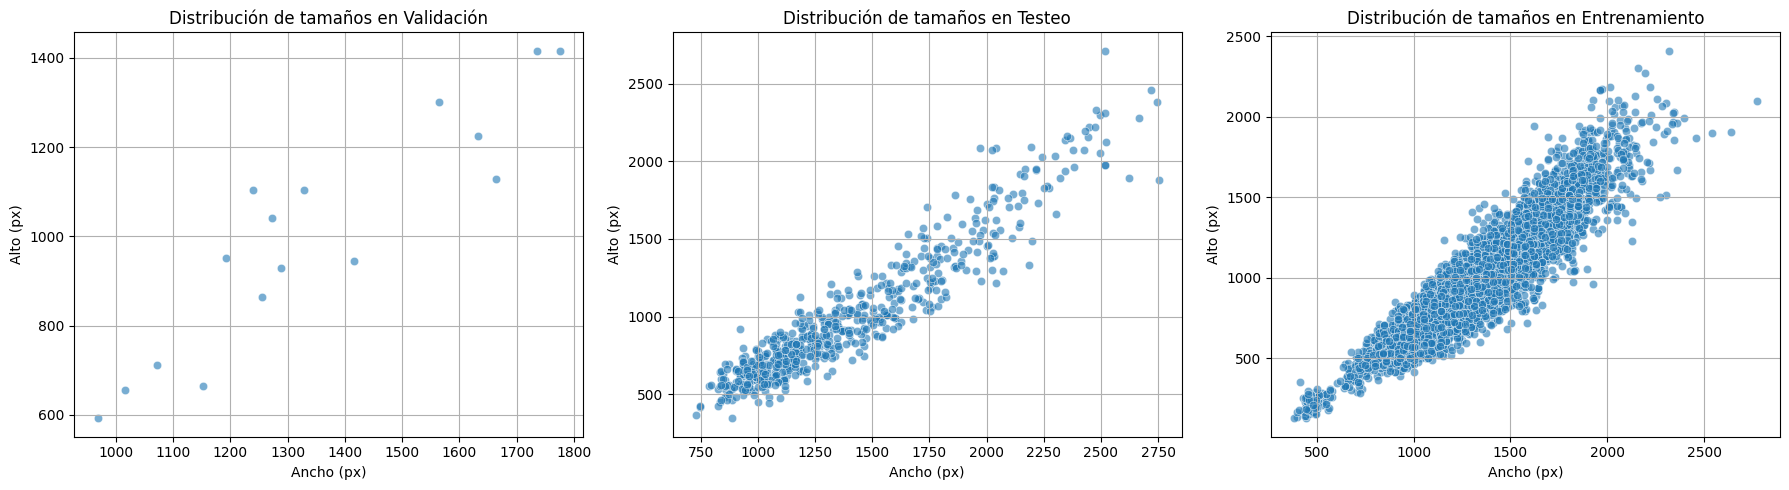

In [86]:
def graficar_tamanos(tamanos, titulo, ax):
    df = pd.DataFrame(tamanos, columns=["Ancho", "Alto"])
    sns.scatterplot(data=df, x="Ancho", y="Alto", alpha=0.6, ax=ax)
    ax.set_title(titulo)
    ax.set_xlabel("Ancho (px)")
    ax.set_ylabel("Alto (px)")
    ax.grid(True)


fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 fila, 3 columnas
graficar_tamanos(tm_vl, "Distribución de tamaños en Validación",axs[0])
graficar_tamanos(tm_ts, "Distribución de tamaños en Testeo",axs[1])
graficar_tamanos(tm_tr, "Distribución de tamaños en Entrenamiento",axs[2])
plt.tight_layout()
plt.show()

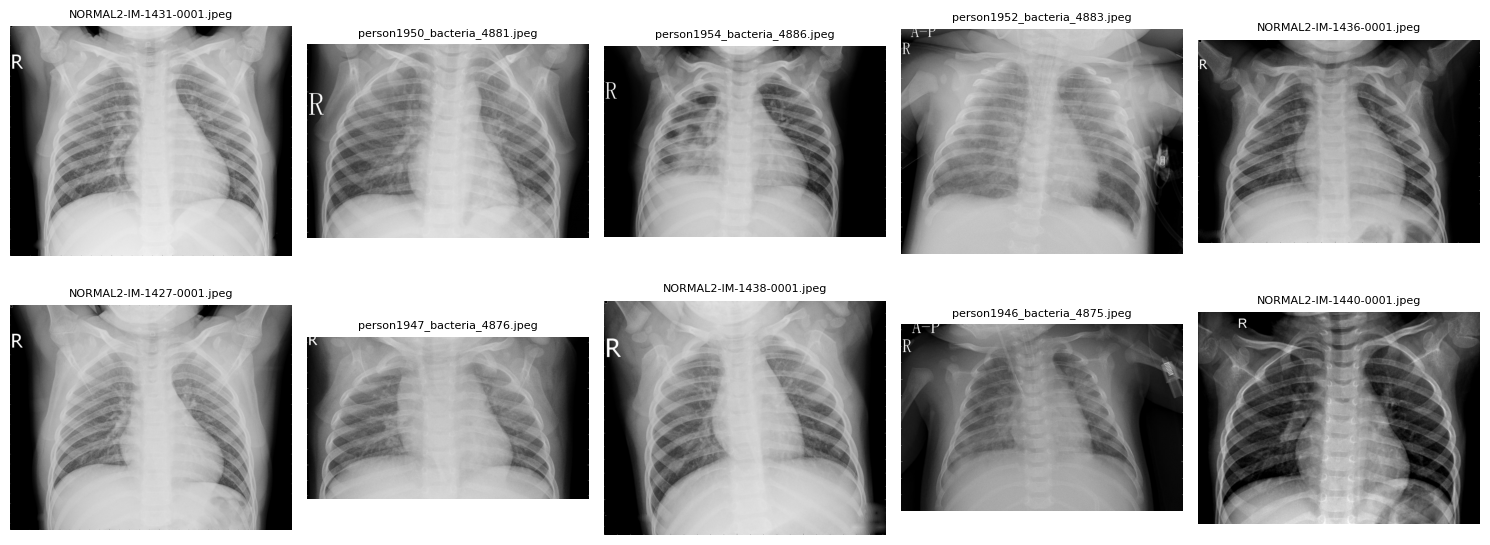

In [91]:
def mostrar_imagenes_aleatorias(ruta_base, cantidad=10):
    from PIL import Image
    import matplotlib.pyplot as plt

    # Recolectar rutas de todas las imágenes
    rutas_imagenes = []
    for subcarpeta in os.listdir(ruta_base):
        ruta_subcarpeta = os.path.join(ruta_base, subcarpeta)
        if os.path.isdir(ruta_subcarpeta):
            for archivo in os.listdir(ruta_subcarpeta):
                rutas_imagenes.append(os.path.join(ruta_subcarpeta, archivo))

    seleccionadas = random.sample(rutas_imagenes, min(cantidad, len(rutas_imagenes)))

    plt.figure(figsize=(15, 6))
    for i, ruta in enumerate(seleccionadas):
        with Image.open(ruta) as img:
            plt.subplot(2, 5, i + 1)
            plt.imshow(img, cmap='gray')  # 'gray' si son escala de grises
            plt.title(os.path.basename(ruta), fontsize=8)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
mostrar_imagenes_aleatorias(img_vali)

# Redimensionamiento

In [93]:
# Parámetros de entrada
tamaño_imagen = (224, 224)
batch_size = 32

# Cargar datasets con redimensionamiento automático
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_train,
    image_size=tamaño_imagen,  # Redimensiona automáticamente
    batch_size=batch_size,
    label_mode='categorical'  # o 'binary' o 'int' según el modelo
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_vali,
    image_size=tamaño_imagen,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_test,
    image_size=tamaño_imagen,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 5144 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


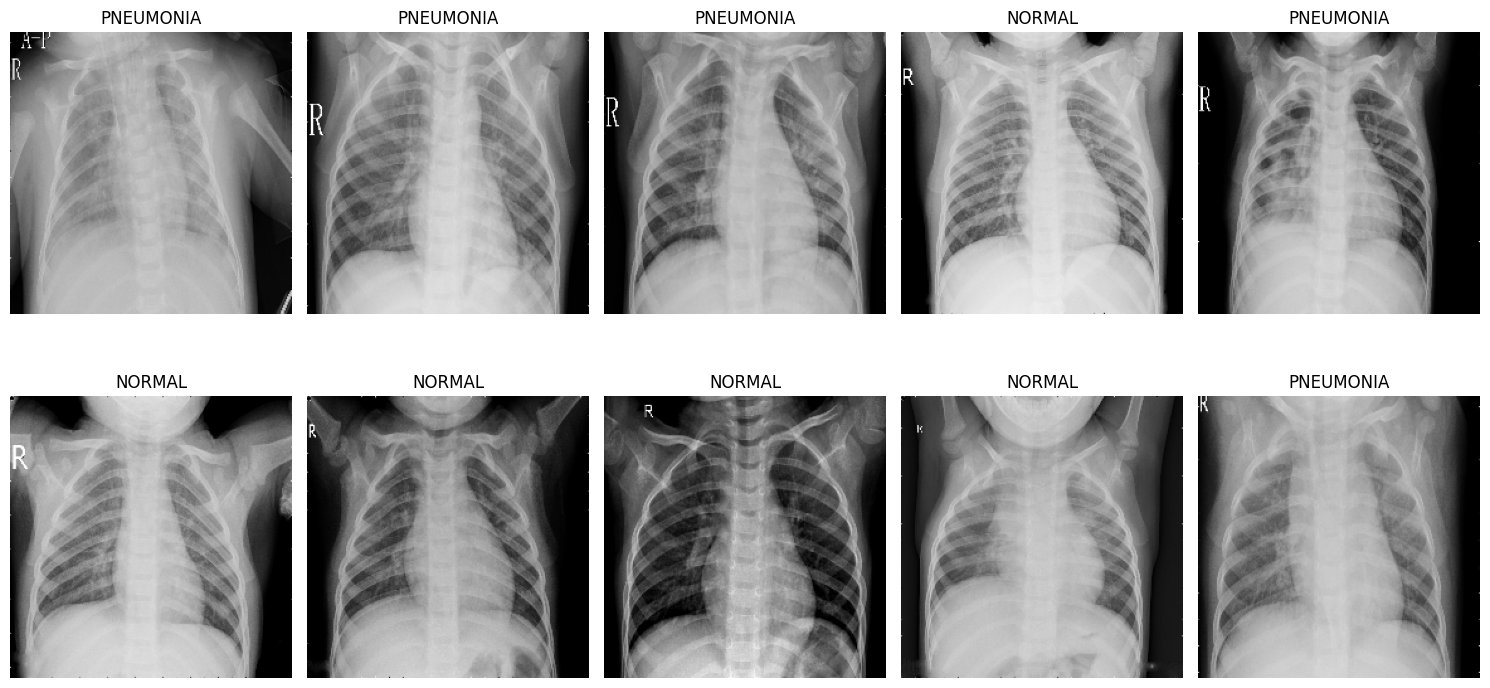

In [95]:
class_names = val_ds.class_names  # ['NORMAL', 'PNEUMONIA']

for images, labels in val_ds.take(1):
    plt.figure(figsize=(15, 8))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = np.argmax(labels[i].numpy())
        plt.title(class_names[class_index])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## redimención de forma local (opcional)

In [ ]:
# def redimensionar_imagenes(ruta_origen, ruta_destino, nuevo_tamano=(224, 224)):
#     if not os.path.exists(ruta_destino):
#         os.makedirs(ruta_destino)

#     for clase in os.listdir(ruta_origen):  # NORMAL, PNEUMONIA
#         ruta_clase_origen = os.path.join(ruta_origen, clase)
#         ruta_clase_destino = os.path.join(ruta_destino, clase)

#         if not os.path.exists(ruta_clase_destino):
#             os.makedirs(ruta_clase_destino)

#         for archivo in os.listdir(ruta_clase_origen):
#             ruta_img_origen = os.path.join(ruta_clase_origen, archivo)
#             ruta_img_destino = os.path.join(ruta_clase_destino, archivo)

#             try:
#                 with Image.open(ruta_img_origen) as img:
#                     img_redimensionada = img.resize(nuevo_tamano)
#                     img_redimensionada.save(ruta_img_destino)
#             except Exception as e:
#                 print(f"Error con {ruta_img_origen}: {e}")
# # Directorios destino
# ruta_base = "/content/drive/MyDrive/Curso IA Samsung /Capstone/data"
# train_out = os.path.join(ruta_base, "train_redim")
# test_out = os.path.join(ruta_base, "test_redim")
# val_out = os.path.join(ruta_base, "val_redim")

# # Redimensionar
# redimensionar_imagenes(train, train_out)
# redimensionar_imagenes(test, test_out)
# redimensionar_imagenes(val, val_out)

# Segmentación

In [ ]:
#En esta sección la idea sera implementar la segmentación, antes de normalizar

# Normalización

In [96]:
normalizar = lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)

train_ds = train_ds.map(normalizar)
val_ds = val_ds.map(normalizar)
test_ds = test_ds.map(normalizar)